Looking at the the tasks from the [Abstraction and Reasoning Corpus](https://github.com/fchollet/ARC), while each task is unique, it is clear that there are certain concepts, such as operations like rotation or mirroring, that occur repeatedly throughout the corpus. What seems feasible is to think of a set of building blocks that encapsulate those concepts that can then be used to build solution programs, that is, task-specific programs that correctly transform each of the input grids of a given task into its corresponding output grid. Such a set of building blocks is a form of domain-specific language (DSL). A DSL defines a set of programs that it can express, and the process of finding or creating such a program solving a given task is a form of program synthesis. Building a good DSL that well captures the explicitly stated core knowledge priors of ARC in an abstract and combinable manner, combined with an adequate program synthesis approach is suggested as a possible way to tackling ARC by its creator François in [On the Measure of Intelligence](https://arxiv.org/abs/1911.01547).

This notebook presents a very simple such DSL tailored to ARC and how it can be used to perform program synthesis, intended to serve as a starting point for anyone new to the ARC benchmark. For the sake of demonstration, the DSL as well as the program synthesis are overly simplistic here, to the point of being naive, as will be demonstrated. First, the DSL is defined as some basic functions, also called primitives, that transform grids. Second, program synthesis as search over compositions of those primitives is performed. The search is naive in that it is a brute force search over all possible primitive compositions up to a certain depth that is done for each task and simply uses the first program it finds to solve the training examples to make predictions for the test examples.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import tqdm
import itertools

from random import sample

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

In [3]:
test_challenges_path = './arc-prize-2024/arc-agi_test_challenges.json'
train_challenges_path = './arc-prize-2024/arc-agi_training_challenges.json'
train_solutions_path = './arc-prize-2024/arc-agi_training_solutions.json'

with open(test_challenges_path) as fp:
    test_challenges = json.load(fp)
with open(train_challenges_path) as fp:
    train_challenges = json.load(fp)
with open(train_solutions_path) as fp:
    train_solutions = json.load(fp)

In [4]:
def plot_task(task):
    """ plots a task """
    examples = task['train']
    n_examples = len(examples)
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    figure, axes = plt.subplots(2, n_examples, figsize=(n_examples * 4, 8))
    for column, example in enumerate(examples):
        axes[0, column].imshow(example['input'], cmap=cmap, norm=norm)
        axes[1, column].imshow(example['output'], cmap=cmap, norm=norm)
        axes[0, column].axis('off')
        axes[1, column].axis('off')
    plt.show()

In [5]:
# defining a handful of basic primitives

def tophalf(grid):
    """ upper half """
    return grid[:len(grid) // 2]


def rot90(grid):
    """ clockwise rotation by 90 degrees """
    return list(zip(*grid[::-1]))


def hmirror(grid):
    """ mirroring along horizontal """
    return grid[::-1]


def compress(grid):
    """ removes frontiers """
    ri = [i for i, r in enumerate(grid) if len(set(r)) == 1]
    ci = [j for j, c in enumerate(zip(*grid)) if len(set(c)) == 1]
    return [[v for j, v in enumerate(r) if j not in ci] for i, r in enumerate(grid) if i not in ri]


def trim(grid):
    """ removes border """
    return [r[1:-1] for r in grid[1:-1]]


# defining the DSL as the set of the primitives

DSL_primitives = {tophalf, rot90, hmirror, compress, trim}
primitive_names = {p.__name__ for p in DSL_primitives}
print(f'DSL consists of {len(DSL_primitives)} primitives: {primitive_names}')

DSL consists of 5 primitives: {'rot90', 'hmirror', 'compress', 'trim', 'tophalf'}


In [6]:
# the maximum composition depth to consider
MAX_DEPTH = 4

# construct the program strings of all programs expressible by composing at most MAX_DEPTH primitives

program_strings = []
for depth in range(1, MAX_DEPTH+1):
    primitive_tuples = itertools.product(*[primitive_names]*depth)
    for primitives in primitive_tuples:
        left_side = "".join([p + "(" for p in primitives])
        right_side = ')' * depth
        program_string = f'lambda grid: {left_side}grid{right_side}'
        program_strings.append(program_string)


# print some of the program strings
print(f'Space to search consists of {len(program_strings)} programs:\n')
print('\n'.join([*program_strings[:10], '...']))


# map program strings to programs
programs = {prog_str: eval(prog_str) for prog_str in program_strings}

Space to search consists of 780 programs:

lambda grid: rot90(grid)
lambda grid: hmirror(grid)
lambda grid: compress(grid)
lambda grid: trim(grid)
lambda grid: tophalf(grid)
lambda grid: rot90(rot90(grid))
lambda grid: rot90(hmirror(grid))
lambda grid: rot90(compress(grid))
lambda grid: rot90(trim(grid))
lambda grid: rot90(tophalf(grid))
...


In [7]:
# for each task, search over the programs and if a working program is found, remember it

guesses = dict()
# iterate over all tasks
for key, task in tqdm.tqdm(train_challenges.items()):
    train_inputs = [example['input'] for example in task['train']]
    train_outputs = [example['output'] for example in task['train']]
    hypotheses = []
    # iterate over all programs
    for program_string, program in programs.items():
        try:
            if all([program(i) == o for i, o in zip(train_inputs, train_outputs)]):
                # remember program if it explains all training examples
                hypotheses.append(program_string)
        except:
            pass
    # select first program for making predictions
    if len(hypotheses) > 0:
        print(f'found {len(hypotheses)} candidate programs for task {key}!')
        guesses[key] = hypotheses[0]
print(f'\nMade guesses for {len(guesses)} tasks')

  8%|██████▋                                                                          | 33/400 [00:01<00:12, 29.35it/s]

found 11 candidate programs for task 1cf80156!


 40%|███████████████████████████████▌                                                | 158/400 [00:05<00:07, 34.27it/s]

found 16 candidate programs for task 68b16354!


 45%|████████████████████████████████████                                            | 180/400 [00:06<00:07, 30.54it/s]

found 3 candidate programs for task 7468f01a!


 60%|████████████████████████████████████████████████▍                               | 242/400 [00:08<00:04, 32.73it/s]

found 4 candidate programs for task 9dfd6313!


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 29.35it/s]


Made guesses for 4 tasks


In [8]:
# make predictions and evaluate them

solved = dict()

# iterate over all tasks for which a guess exists
for key, program_string in guesses.items():
    test_inputs = [example['input'] for example in train_challenges[key]['test']]
    program = eval(program_string)
    if all([program(i) == o for i, o in zip(test_inputs, train_solutions[key])]):
        # mark predition as correct if all test examples are solved by the program
        solved[key] = program_string


print(f'Predictions correct for {len(solved)}/{len(guesses)} tasks')

Predictions correct for 4/4 tasks


For task "1cf80156", found program "lambda grid: compress(grid)"


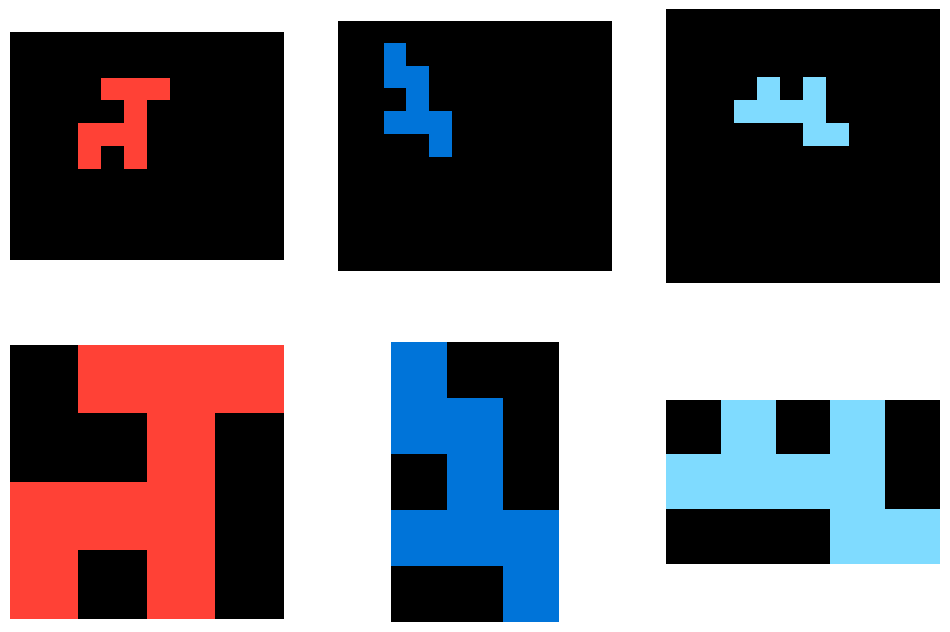

For task "68b16354", found program "lambda grid: hmirror(grid)"


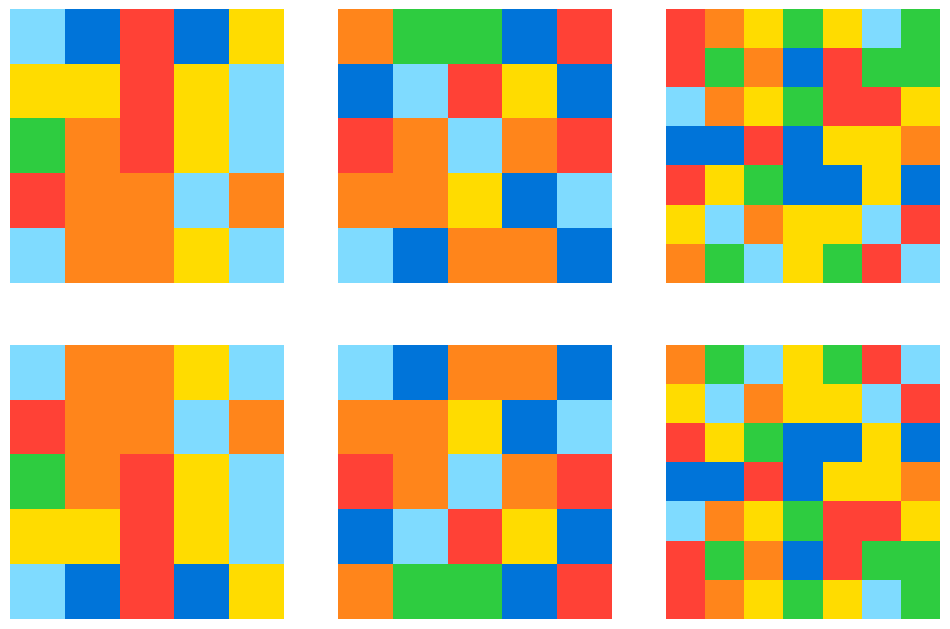

For task "7468f01a", found program "lambda grid: hmirror(compress(rot90(rot90(grid))))"


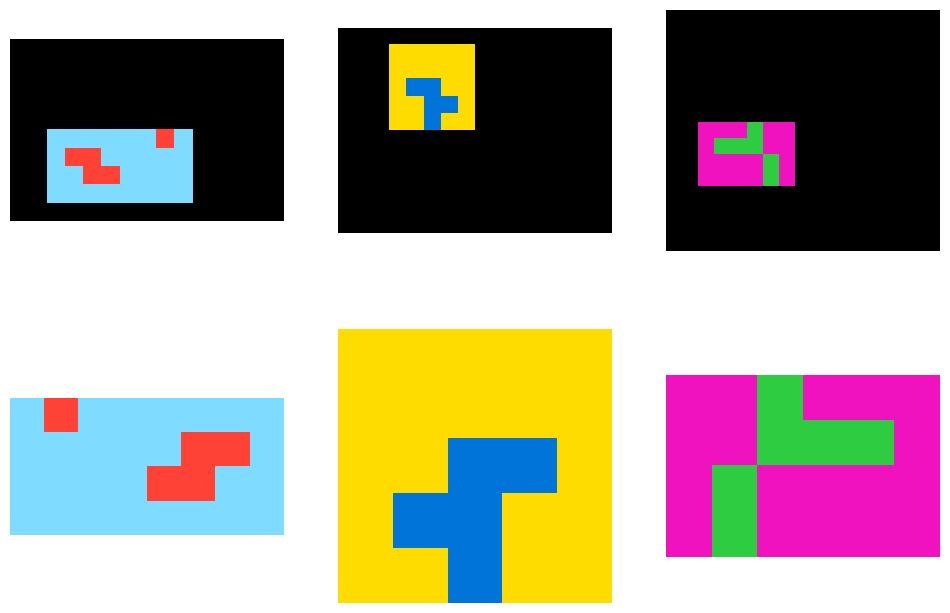

For task "9dfd6313", found program "lambda grid: compress(rot90(hmirror(grid)))"


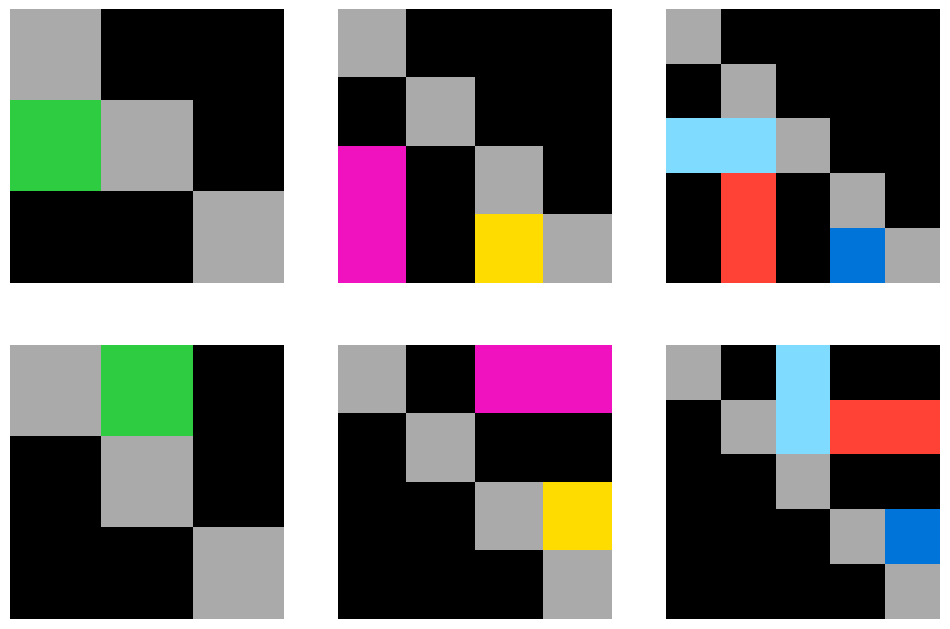

In [10]:
# visualize solved tasks
for key, program_string in solved.items():
    print(f'For task "{key}", found program "{program_string}"')
    plot_task(train_challenges[key])

While this code runs extremely fast (considering 400 tasks in less than 10 seconds), it also performs extremely poor (solving only 4/400 tasks, giving a mere 1% accuracy). How could it be improved? What can be learned from it? There are at least two issues with the above approach to searching a space of programs expressible in a DSL: First, the DSL provided here is not very expressive in that for most tasks, no program that solves it exists in the set of all possible programs buildable in the DSL. Second, even if sufficient expressivity is guaranteed (e.g. via a turing-complete DSL), for which by definition there would exist solution programs to each task, such programs may in practice either not be discoverable in the first place or not detectable as correct programs.

### Increasing DSL Expressivity
It is obvious why some tasks can't be solved by the above DSL, but one simple proof would be the following: No primitive ever increases the pixel count of a grid, hence neither can any composition of the primitives ever do so - and since for certain tasks, the output grids do have more pixels than the input grids, the DSL is incomplete. To increase the expressibity of the program space (disregarding the maximum program size), one will want to expand the set of the primitives and also extend the structure of the considered programs beyond mere composition. Maybe it is a good idea to have primitives which take more than one input argument, or primitives that operate on types other than only grids, such as objects or integers. Note that viewing the transformations from inputs to outputs as a linear function composition is very misleading, as many tasks can't be neatly squeezed into this form: Some tasks seem much better addressed on a pixel- or object-level than on a grid-level. A good DSL is probably concise and allows expressing solutions to many tasks as short programs. Such a DSL may best be built by bootstrapping, that is, building a minimal version of it and then iterating back and forth between using it to solve ARC tasks and expanding it to account for unsolvable ARC tasks, all while having abstractness and flexibility of the primitives and how they can interplay in mind.

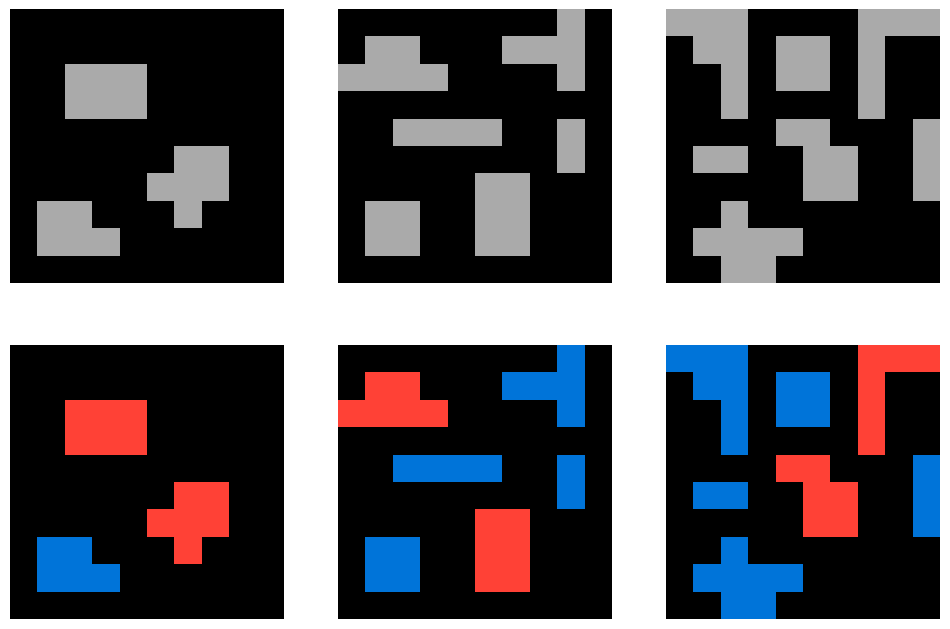

In [11]:
# example of task where above DSL is ill-suited and e.g. an object-centric view could be more appropriate.
# Potentially useful primitives: object extraction, property detection (has 6 pixels) and transformations (recolor)
plot_task(train_challenges['d2abd087'])

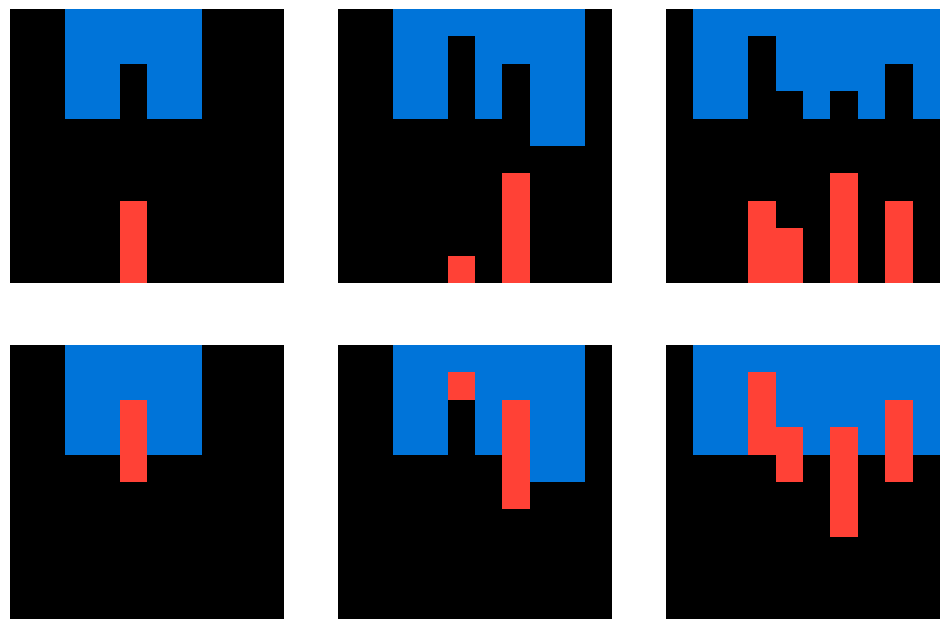

In [12]:
# example of task where above DSL is ill-suited and e.g. a more pixel-centric view could be more appropriate.
# Potentially useful: cellular automata
plot_task(train_challenges['3906de3d'])

### Increasing Search Efficiency
To increase the efficiency of the search for programs, it is crucial to avoid a brute force search, as it very quickly becomes entirely infeasible as the size of the programs and the number of primitives grow: Even for a simplistic DSL where the primitives can only interact with each other via composition, if it consists of p primitives and one wants to check all programs up to depth d, the number of programs to consider with grow on the order of $p^d$.

Naively, "pruning the search space" or avoiding considering primitives or subprograms unlikely useful for a solution program could be addressed by building heuristics into the search, e.g. "whenever the output grid is always of the same size as the input grid for all training examples, don't consider grid rescaling operations during the search". However, not only would such an approach be extremely labour-intensive, but also likely prone to result in a brittle and static system that would performs poorly. Maybe the navigation of the search space is something that can or even should be learned, not hardcoded.

In [13]:
# some calculations on infeasibility of brute force search
pd_arr = [(p, d) for p in [8, 16, 32] for d in [2, 4, 8]]
for p, d in sorted(pd_arr, key=lambda pd: pd[0]**pd[1]):
    print(f'DSL with {p} primitives and max. depth {d} allows > {p**d} programs')

DSL with 8 primitives and max. depth 2 allows > 64 programs
DSL with 16 primitives and max. depth 2 allows > 256 programs
DSL with 32 primitives and max. depth 2 allows > 1024 programs
DSL with 8 primitives and max. depth 4 allows > 4096 programs
DSL with 16 primitives and max. depth 4 allows > 65536 programs
DSL with 32 primitives and max. depth 4 allows > 1048576 programs
DSL with 8 primitives and max. depth 8 allows > 16777216 programs
DSL with 16 primitives and max. depth 8 allows > 4294967296 programs
DSL with 32 primitives and max. depth 8 allows > 1099511627776 programs


### Outlook

Creating your own DSL from scratch will probably not be easy and may not be desired or needed in the first place. There are at least two open-source DSLs for ARC, for example [Johan's DSL](https://github.com/top-quarks/ARC-solution) which he also used to win the first ARC-competition in 2020 with 20.6% by having efficient implementations and simple primitive signatures rendering a large-scale search feasible. Alternatively, I have built a separate, less minimal [ARC-DSL](https://github.com/michaelhodel/arc-dsl) that comes alongside reference [solution programs for all 400 ARC training tasks](https://github.com/michaelhodel/arc-dsl/blob/main/solvers.py) and which was also used for more recent program synthesis approaches such as [CodeIt](https://arxiv.org/pdf/2402.04858) that may be useful, even if just as inspiration. However, not following other's footsteps can also have benefits, such as not having to work with something that may be suboptimal for the desired approach at hand and by that getting stuck in a local minimum, and maybe a more adequate DSL for ARC is yet to be created, maybe by you!

And, of course, using a DSL and searching over it is by no means the only way or all there is to ARC. Arguably, much work is yet to be done, and novelty and diversity in approaches seem in dire need to make progress on the benchmark, and with that hopefully ultimaltely towards much more advanced AI.

Happy ARC-ing and good luck with the ARC-prize!

In [14]:
# let's try to make a submission

submission = dict()
# iterate over all tasks
for key, task in tqdm.tqdm(test_challenges.items()):
    train_inputs = [example['input'] for example in task['train']]
    train_outputs = [example['output'] for example in task['train']]
    hypotheses = []
    # iterate over all programs
    for program_string, program in programs.items():
        try:
            if all([program(i) == o for i, o in zip(train_inputs, train_outputs)]):
                # remember program if it explains all training examples
                hypotheses.append(program_string)
        except:
            pass
    # select first program for making predictions
    predictions = [example['input'] for example in task['test']]
    if len(hypotheses) > 0:
        print(f'found {len(hypotheses)} candidate programs for task {key}!')
        program_string = hypotheses[0]
        program = eval(program_string)
        try:
            predictions = [program(example['input']) for example in task['test']]
        except:
            pass
    submission[key] = [{'attempt_1': grid, 'attempt_2': grid} for grid in predictions]
print(f'\nMade guesses for {len(guesses)} tasks')

with open('submission.json', 'w') as fp:
    json.dump(submission, fp)

 33%|██████████████████████████▋                                                      | 33/100 [00:01<00:02, 29.69it/s]

found 11 candidate programs for task 1cf80156!


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]


Made guesses for 4 tasks
